In [1]:
library (caret)
library (Amelia)
library (plyr)
library (dplyr)
library (ggplot2)
library (lubridate)
library (xgboost)

source ("support.R")

train.df <- read.csv ("data/train.csv")
test.df <- read.csv ("data/test.csv")

train.df <- formatData (train.df, logTransform=TRUE) %>% tbl_df()
test.df <- formatData (test.df) %>% tbl_df()

Loading required package: lattice
Loading required package: ggplot2
Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.3, built: 2014-11-14)
## Copyright (C) 2005-2016 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:plyr’:

    here


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



In [2]:
source ("xgbDirect-CV-casual.R")

[0]	train-rmse:2.644002+0.005642	test-rmse:2.643950+0.022814
[1]	train-rmse:2.620333+0.005623	test-rmse:2.620275+0.022749
[2]	train-rmse:2.596941+0.005583	test-rmse:2.596860+0.022672
[3]	train-rmse:2.573770+0.005565	test-rmse:2.573698+0.022568
[4]	train-rmse:2.550898+0.005512	test-rmse:2.550843+0.022526
[5]	train-rmse:2.528280+0.005484	test-rmse:2.528254+0.022454
[6]	train-rmse:2.505882+0.005435	test-rmse:2.505875+0.022395
[7]	train-rmse:2.483733+0.005364	test-rmse:2.483746+0.022366
[8]	train-rmse:2.461801+0.005343	test-rmse:2.461813+0.022275
[9]	train-rmse:2.440119+0.005320	test-rmse:2.440195+0.022159
[10]	train-rmse:2.418709+0.005288	test-rmse:2.418761+0.022127
[11]	train-rmse:2.397548+0.005268	test-rmse:2.397679+0.021984
[12]	train-rmse:2.376541+0.005215	test-rmse:2.376705+0.021892
[13]	train-rmse:2.355815+0.005188	test-rmse:2.355986+0.021814
[14]	train-rmse:2.335315+0.005114	test-rmse:2.335535+0.021704
[15]	train-rmse:2.315029+0.005073	test-rmse:2.315272+0.021704
[16]	train-rmse:2.

In [4]:
resid <- fit$pred - train.df$casual

In [35]:
lowerq <- quantile (resid)[2]
upperq <- quantile (resid)[4]
iqr <- upperq - lowerq
highOutlierIndices <- resid > (upperq + 1.5*iqr)
lowOutlierIndices <- resid < (lowerq - 1.5*iqr)

In [63]:
highOutliers <- filter (train.df, highOutlierIndices %in% row_number()) %>% 
    mutate (resid=resid[highOutlierIndices], fitCasual=fit$pred[highOutlierIndices])
                                                                                   
lowOutliers <- filter (train.df, lowOutlierIndices %in% row_number()) %>% 
    mutate (resid=resid[lowOutlierIndices], fitCasual=fit$pred[lowOutlierIndices])

##Let's understand low outliers first

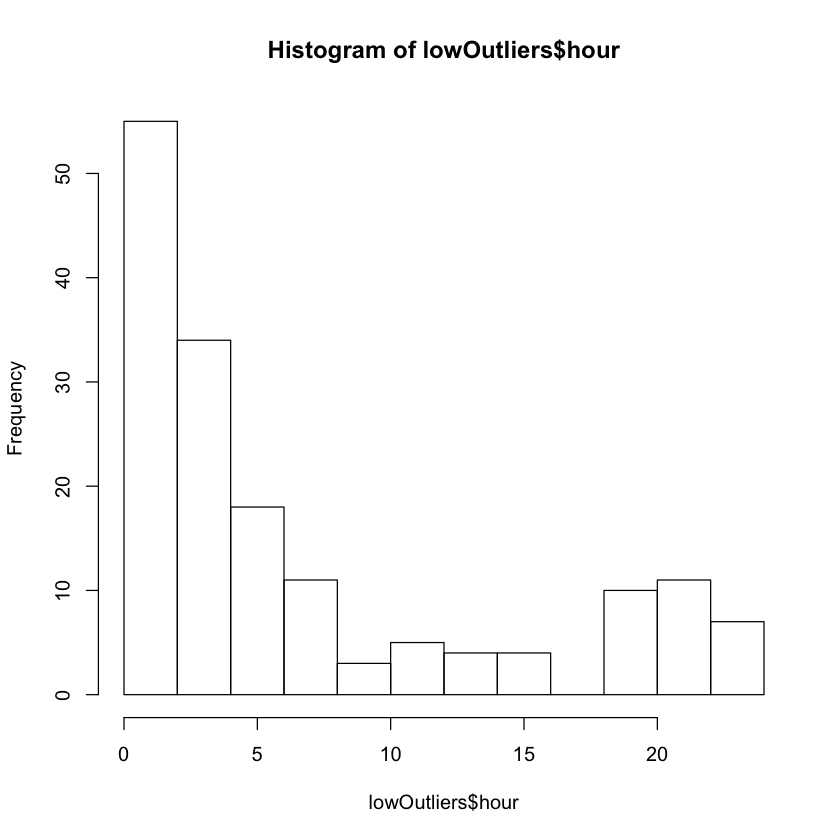

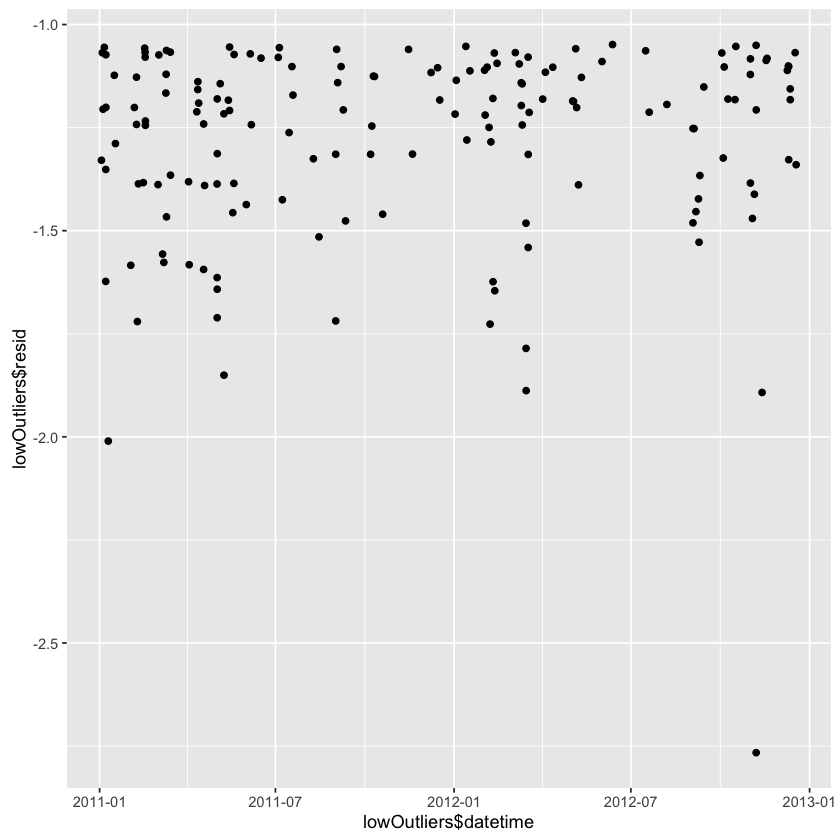

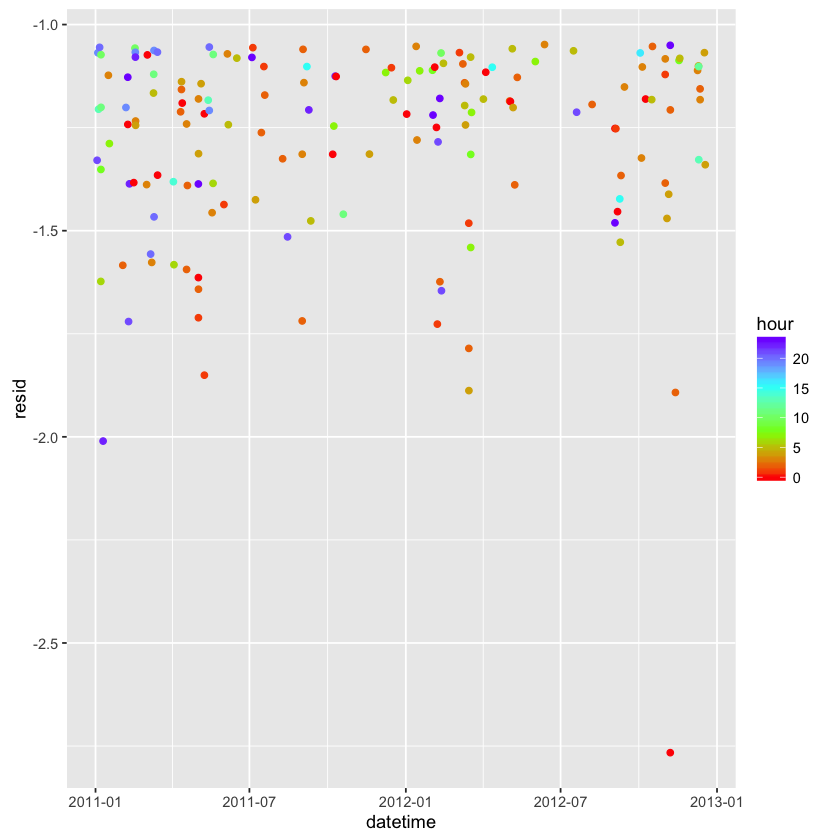

In [69]:
hist (lowOutliers$hour)
qplot (lowOutliers$datetime, lowOutliers$resid)
ggplot (lowOutliers, aes (x=datetime, y=resid, color=hour)) + geom_point() + scale_colour_gradientn(colours=rainbow(4))

In [70]:
arrange (lowOutliers, resid) %>% select (datetime, casual, fitCasual, resid)

[1] 2.712439

ERROR: Error in as.POSIXlt.character(x, tz, ...): character string is not in a standard unambiguous format


Source: local data frame [162 x 4]

              datetime   casual  fitCasual     resid
1  2012-11-07 00:00:00 3.912023  1.1459771 -2.766046
2  2011-01-09 22:00:00 1.791759 -0.2185350 -2.010294
3  2012-11-13 02:00:00 2.079442  0.1870519 -1.892390
4  2012-03-15 04:00:00 2.484907  0.5970026 -1.887904
5  2011-05-09 01:00:00 3.258097  1.4076638 -1.850433
6  2012-03-15 02:00:00 2.708050  0.9225698 -1.785480
7  2012-02-07 01:00:00 2.197225  0.4706463 -1.726578
8  2011-02-08 21:00:00 2.197225  0.4768632 -1.720361
9  2011-09-01 02:00:00 2.708050  0.9891551 -1.718895
10 2011-05-02 01:00:00 3.737670  2.0265627 -1.711107
..                 ...      ...        ...       ...

### Causes for outliers
- Nov 7, 2012 - Election results
- Seems hard to assign causes to main outliers
- We could try to create a separate variable for hour < 5 

## Let's understand high outliers now

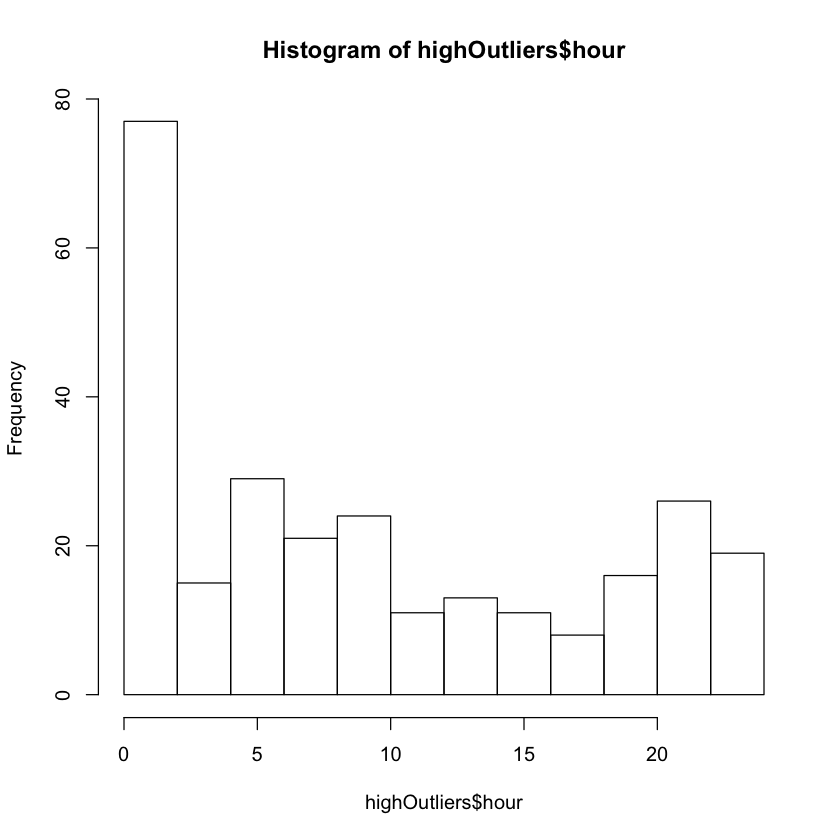

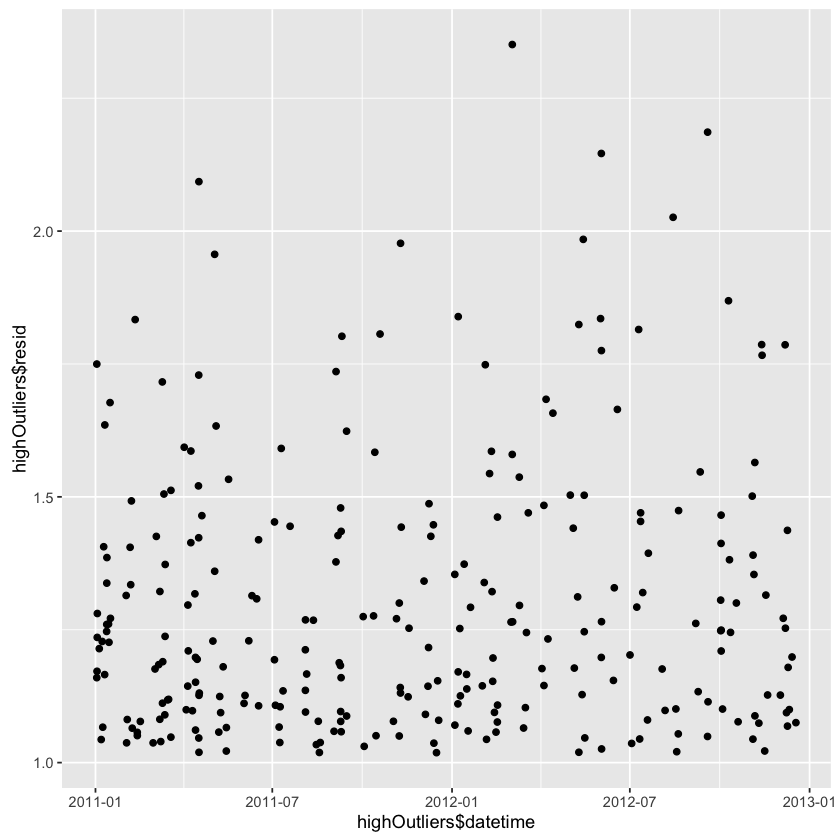

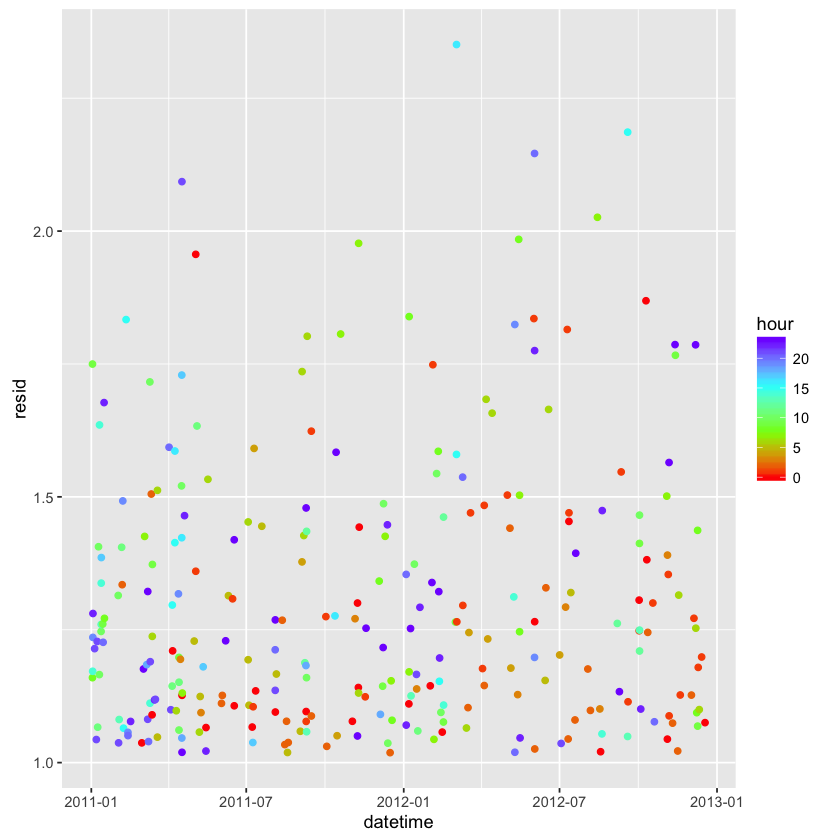

In [82]:
hist (highOutliers$hour)
qplot (highOutliers$datetime, highOutliers$resid)
ggplot (highOutliers, aes (x=datetime, y=resid, color=hour)) + geom_point() + scale_colour_gradientn(colours=rainbow(4))

In [83]:
table (train.df$weather)/nrow (train.df)
table (highOutliers$weather)/nrow (highOutliers)


          clear          cloudy lightRainOrSnow       heavyRain 
   6.606651e-01    2.603344e-01    7.890869e-02    9.186111e-05 


          clear          cloudy lightRainOrSnow       heavyRain 
      0.5000000       0.3259259       0.1740741       0.0000000 

In [74]:
arrange (highOutliers, desc (resid)) %>% select (datetime, casual, fitCasual, resid, weather)

ERROR: Error in as.POSIXlt.character(x, tz, ...): character string is not in a standard unambiguous format


Source: local data frame [270 x 5]

              datetime    casual fitCasual    resid         weather
1  2012-03-02 16:00:00 0.6931472  3.044104 2.350957 lightRainOrSnow
2  2012-09-18 15:00:00 0.6931472  2.879287 2.186140 lightRainOrSnow
3  2012-06-01 20:00:00 0.6931472  2.839169 2.146022 lightRainOrSnow
4  2011-04-16 21:00:00 0.6931472  2.786152 2.093005          cloudy
5  2012-08-14 07:00:00 0.6931472  2.719091 2.025944          cloudy
6  2012-05-14 08:00:00 0.6931472  2.677563 1.984416 lightRainOrSnow
7  2011-11-09 07:00:00 0.0000000  1.977015 1.977015           clear
8  2011-05-03 00:00:00 0.0000000  1.956249 1.956249          cloudy
9  2012-10-10 00:00:00 0.0000000  1.868920 1.868920          cloudy
10 2012-01-07 08:00:00 0.0000000  1.839081 1.839081           clear
..                 ...       ...       ...      ...             ...

##Let's investigate the model for registered users

In [2]:
source ("xgbDirect-CV-registered.R")

[0]	train-rmse:4.128038+0.009300	test-rmse:4.127949+0.038497
[1]	train-rmse:4.116309+0.009284	test-rmse:4.116228+0.038426
[2]	train-rmse:4.104916+0.009572	test-rmse:4.104834+0.038079
[3]	train-rmse:4.093727+0.009631	test-rmse:4.093665+0.037998
[4]	train-rmse:4.082368+0.009880	test-rmse:4.082322+0.037682
[5]	train-rmse:4.071089+0.010167	test-rmse:4.071023+0.037292
[6]	train-rmse:4.059815+0.009882	test-rmse:4.059774+0.037517
[7]	train-rmse:4.048573+0.009944	test-rmse:4.048549+0.037446
[8]	train-rmse:4.037364+0.010050	test-rmse:4.037338+0.037363
[9]	train-rmse:4.026203+0.009960	test-rmse:4.026187+0.037344
[10]	train-rmse:4.015220+0.009801	test-rmse:4.015227+0.037362
[11]	train-rmse:4.004281+0.009483	test-rmse:4.004315+0.037595
[12]	train-rmse:3.993059+0.009379	test-rmse:3.993097+0.037570
[13]	train-rmse:3.981711+0.009338	test-rmse:3.981752+0.037510
[14]	train-rmse:3.970702+0.009245	test-rmse:3.970768+0.037492
[15]	train-rmse:3.959574+0.009156	test-rmse:3.959661+0.037490
[16]	train-rmse:3.

In [3]:
resid <- fit$pred - train.df$registered

In [25]:
lowerq <- quantile (resid)[2]
upperq <- quantile (resid)[4]
iqr <- upperq - lowerq
highOutlierIndices <- resid > (upperq + 1.5*iqr)
lowOutlierIndices <- resid < (lowerq - 1.5*iqr)

outlierDF <- train.df
outlierDF$class <- 0
outlierDF[highOutlierIndices, ]$class <- 1
outlierDF[lowOutlierIndices, ]$class <- -1
outlierDF$class <- factor (outlierDF$class)

In [5]:
highOutliers <- filter (train.df, highOutlierIndices %in% row_number()) %>% 
    mutate (resid=resid[highOutlierIndices], fitRegistered=fit$pred[highOutlierIndices])
                                                                                   
lowOutliers <- filter (train.df, lowOutlierIndices %in% row_number()) %>% 
    mutate (resid=resid[lowOutlierIndices], fitRegistered=fit$pred[lowOutlierIndices])

###Let's understand low outliers first

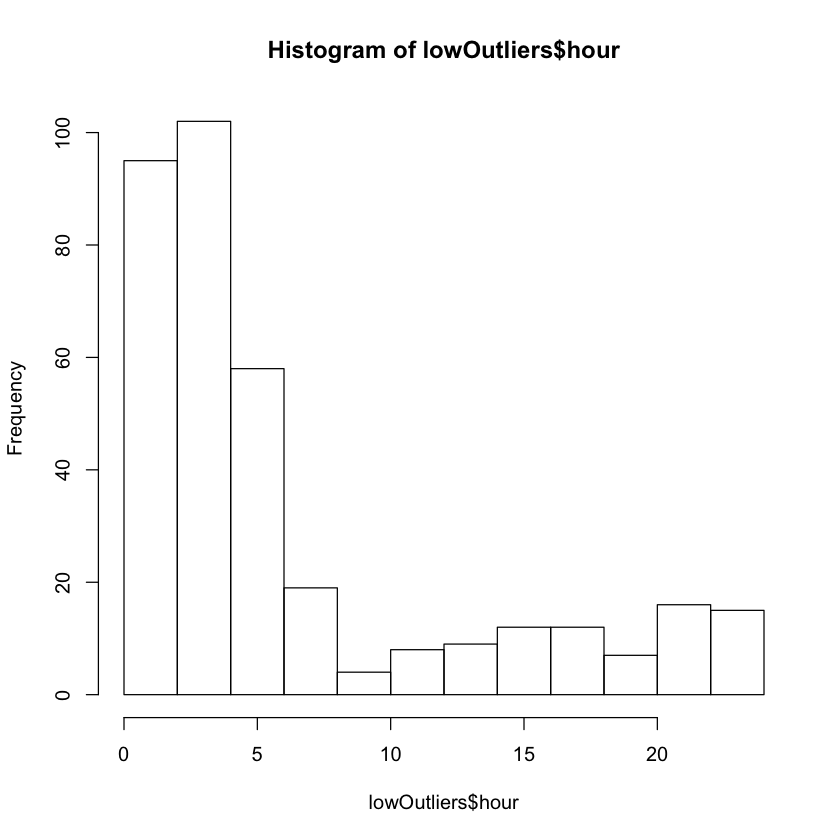

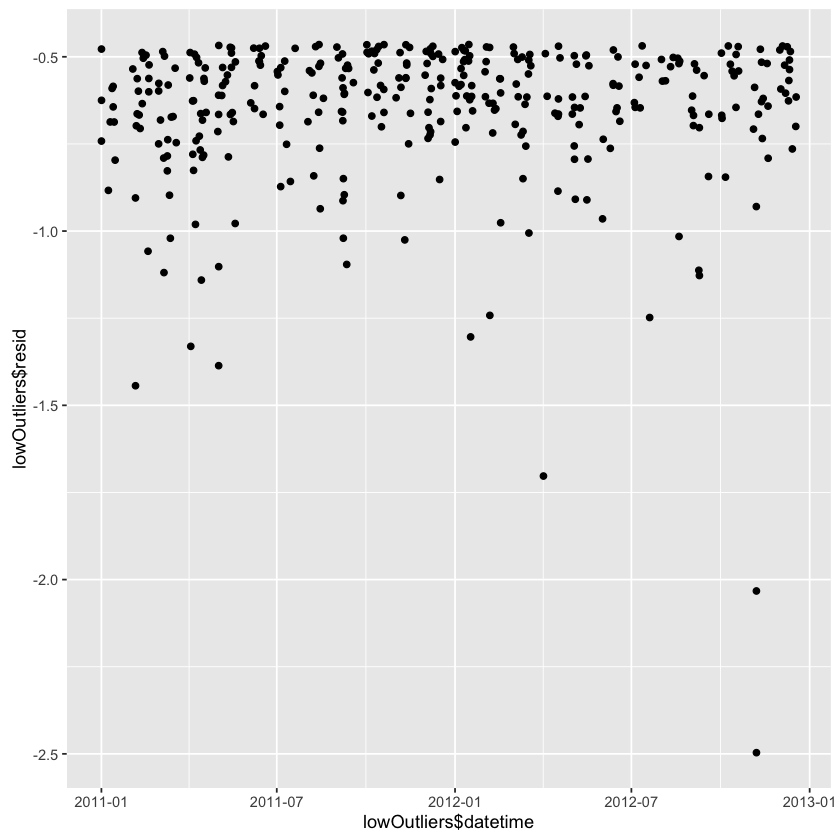

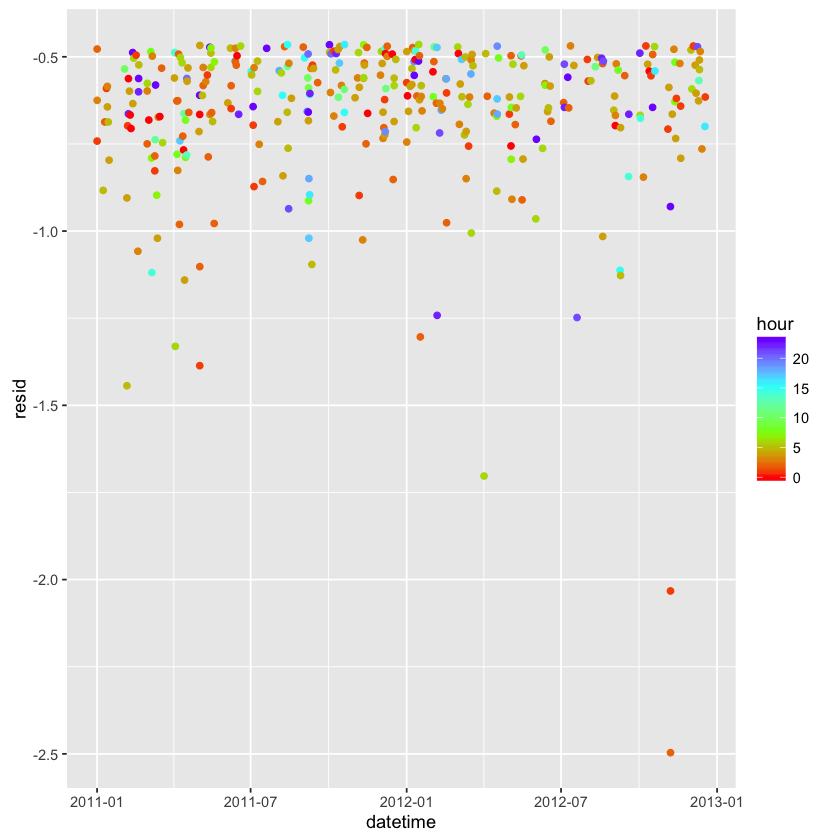

In [6]:
hist (lowOutliers$hour)
qplot (lowOutliers$datetime, lowOutliers$resid)
ggplot (lowOutliers, aes (x=datetime, y=resid, color=hour)) + geom_point() + scale_colour_gradientn(colours=rainbow(4))

In [9]:
arrange (lowOutliers, resid) %>% select (datetime, registered, hour, fitRegistered, resid)

ERROR: Error in as.POSIXlt.character(x, tz, ...): character string is not in a standard unambiguous format


Source: local data frame [357 x 5]

              datetime registered hour fitRegistered     resid
1  2012-11-07 02:00:00   4.234107    2     1.7375348 -2.496572
2  2012-11-07 01:00:00   4.465908    1     2.4332652 -2.032643
3  2012-04-01 06:00:00   4.488636    6     2.7857072 -1.702929
4  2011-02-05 05:00:00   2.302585    5     0.8587855 -1.443800
5  2011-05-02 01:00:00   4.304065    1     2.9178410 -1.386224
6  2011-04-03 06:00:00   3.178054    6     1.8472435 -1.330810
7  2012-01-17 02:00:00   2.564949    2     1.2612950 -1.303654
8  2012-07-19 21:00:00   5.686975   21     4.4388952 -1.248080
9  2012-02-05 22:00:00   5.209486   22     3.9675782 -1.241908
10 2011-04-14 04:00:00   2.197225    4     1.0565736 -1.140651
..                 ...        ...  ...           ...       ...

##Let's Investigate High outliers

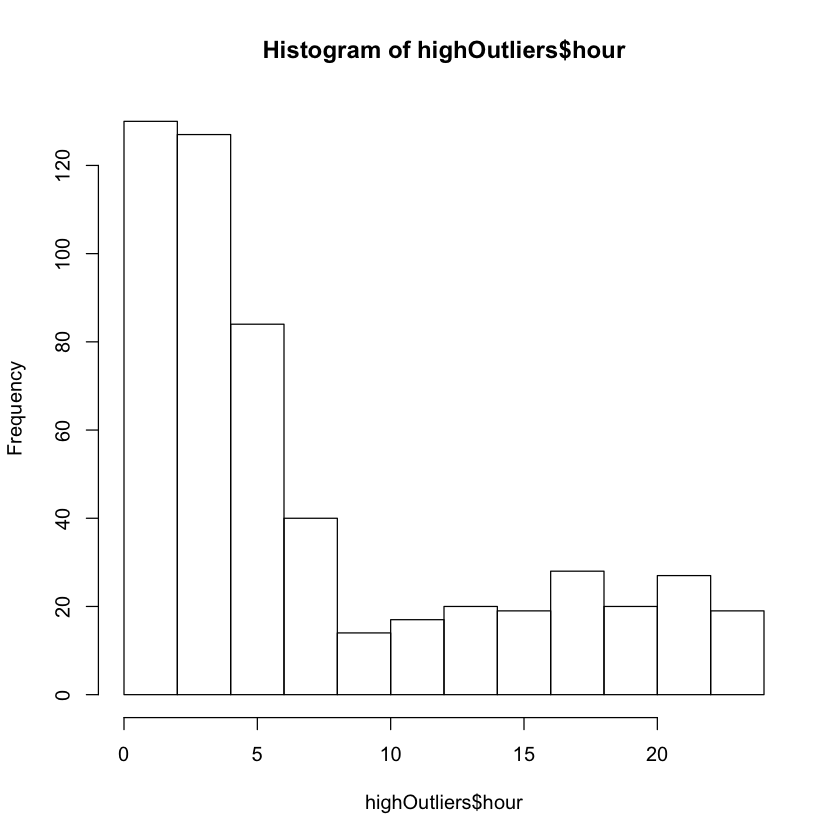

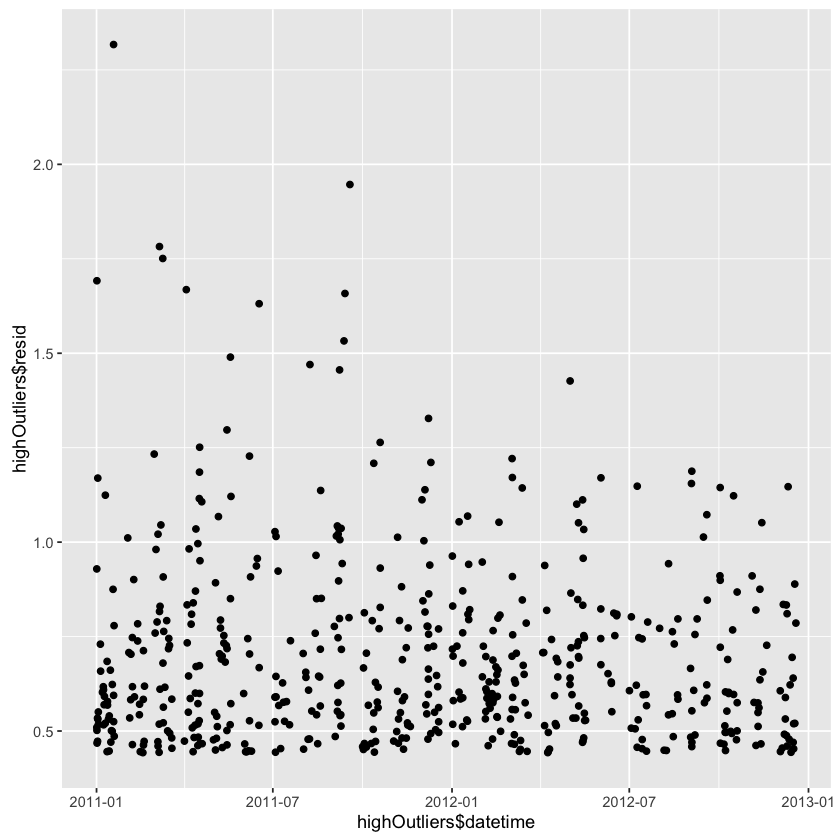

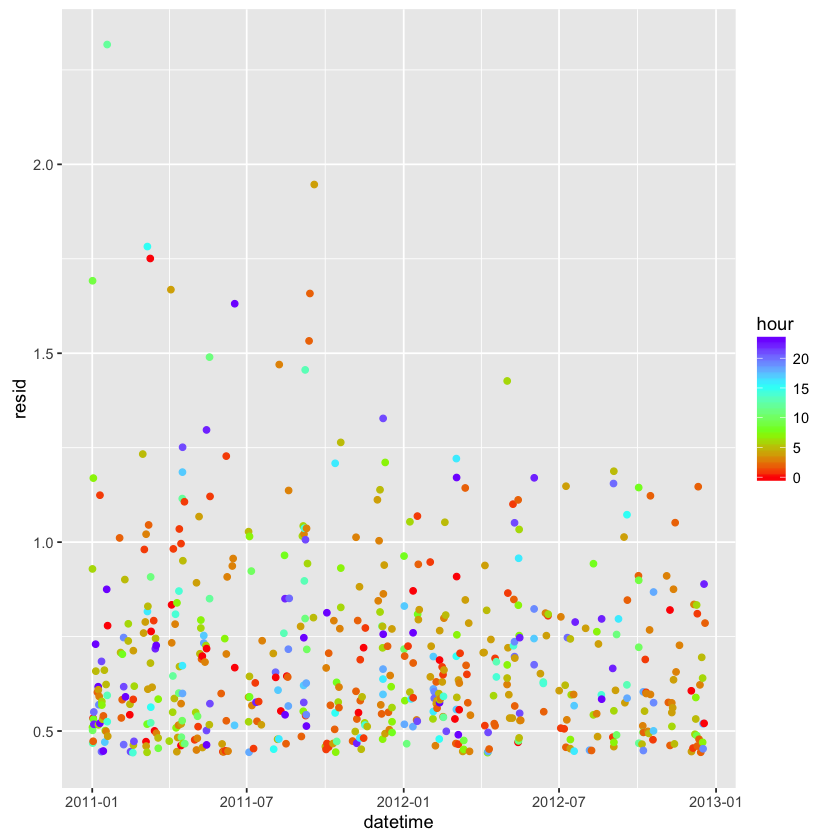

In [20]:
hist (highOutliers$hour)
qplot (highOutliers$datetime, highOutliers$resid)
ggplot (highOutliers, aes (x=datetime, y=resid, color=hour)) + geom_point() + scale_colour_gradientn(colours=rainbow(4))

In [22]:
arrange (highOutliers, desc (resid)) %>% select (datetime, casual, fitRegistered, resid, weather)

ERROR: Error in as.POSIXlt.character(x, tz, ...): character string is not in a standard unambiguous format


Source: local data frame [545 x 5]

              datetime    casual fitRegistered    resid         weather
1  2011-01-18 12:00:00 0.0000000      3.703425 2.317131          cloudy
2  2011-09-18 04:00:00 0.6931472      1.946589 1.946589           clear
3  2011-03-06 15:00:00 1.3862944      3.391828 1.782390 lightRainOrSnow
4  2011-03-10 00:00:00 1.3862944      1.750812 1.750812 lightRainOrSnow
5  2011-01-01 09:00:00 2.1972246      3.637765 1.691855           clear
6  2011-04-03 04:00:00 1.3862944      1.668306 1.668306           clear
7  2011-09-13 02:00:00 1.0986123      1.658191 1.658191           clear
8  2011-06-16 23:00:00 1.0986123      4.339136 1.631085 lightRainOrSnow
9  2011-09-12 02:00:00 1.0986123      1.532650 1.532650           clear
10 2011-05-18 11:00:00 1.9459101      4.380101 1.489729          cloudy
..                 ...       ...           ...      ...             ...

##Let's try to find if there is a pattern to under/over prediction

In [37]:
library (randomForest)
outlierModel <- randomForest (class ~ season + holiday + workingday + weather + temp + atemp +
        humidity + windspeed + year + month + wday + day + hour + registered + casual, 
                     data=outlierDF, mtry=8, importance=TRUE)


Call:
 randomForest(formula = class ~ season + holiday + workingday +      weather + temp + atemp + humidity + windspeed + year + month +      wday + day + hour, data = outlierDF, mtry = 8, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 8

        OOB estimate of  error rate: 9.31%
Confusion matrix:
   -1    0  1 class.error
-1  8  316 33  0.97759104
0  49 9841 92  0.01412543
1  30  493 22  0.95963303

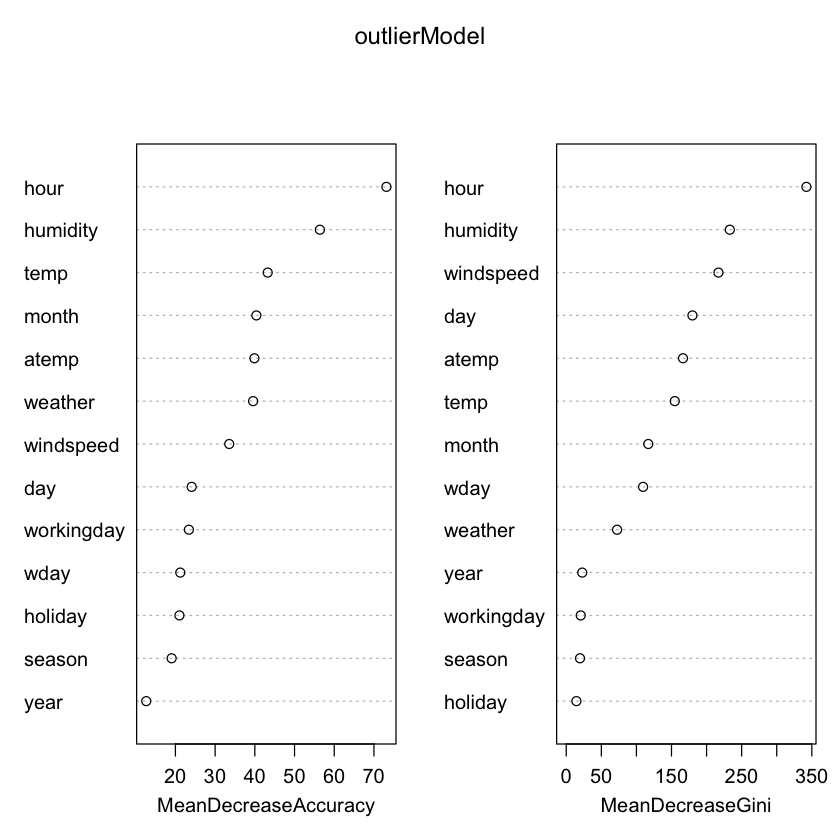

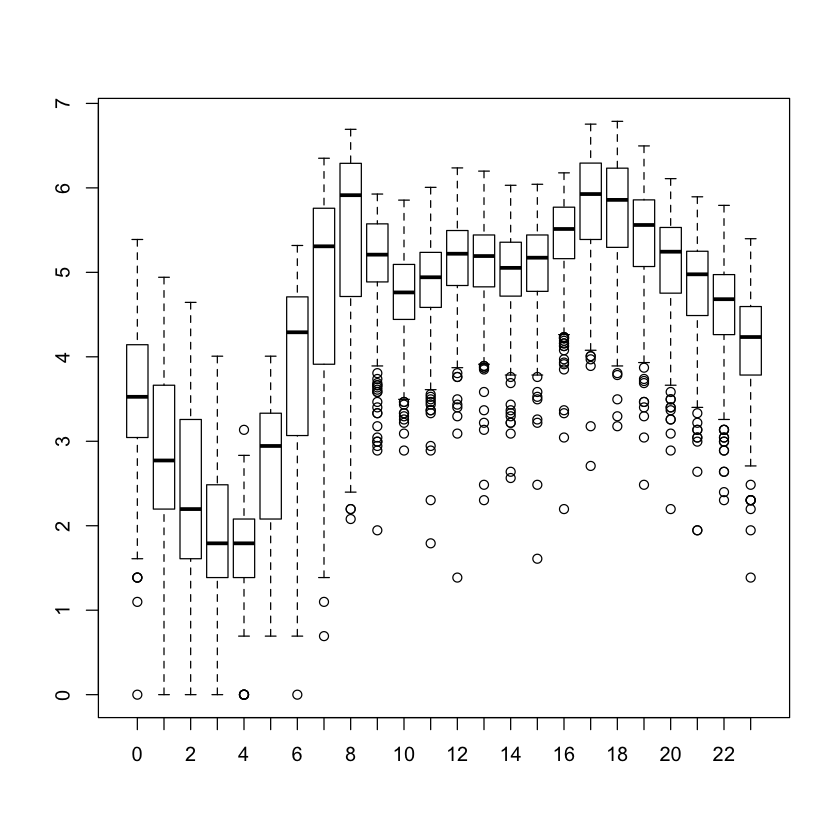

In [36]:
outlierModel
varImpPlot (outlierModel)
boxplot (registered ~ hour, outlierDF)